# Intelligent Control and Fault Diagnosis
### Homework 2
### RBF Neural Networks
### Quad car suspensions

## Define Controller and Identifier

In [110]:
import numpy as np
import matplotlib.pyplot as plt

class RBFNN_Controller:
    def __init__(self, input_dim, num_neurons, eta_1=0.3, eta_2=0.005, eta_3=0.02):
        self.num_neurons = num_neurons
        self.eta_1 = eta_1
        self.eta_2 = eta_2
        self.eta_3 = eta_3

        self.v = np.random.uniform(-0.01, 5, (num_neurons, 1))
        self.sigma_c = np.random.uniform(0.5, 3, num_neurons).reshape(-1, 1)
        self.mu_c = np.random.uniform(-1, 1, (num_neurons, input_dim))

    def normalize_input(self, X):
        return (X - np.mean(X, axis=0)) / (np.std(X, axis=0) + 1e-4)

    def forward(self, input_):
        input_ = self.normalize_input(input_)
        psi = np.exp(-np.sum((input_ - self.mu_c) ** 2 / (2 * self.sigma_c ** 2), axis=1))
        out = np.dot(psi, self.v)
        return out.squeeze(), psi.reshape(-1, 1)

    def update_weights(self, input_, e, psi, u, param_id):
        input_ = self.normalize_input(input_)
        phi = param_id["phi"]
        w = param_id["w"]
        mu = param_id["mu"]
        sigma = param_id["sigma"]
        grad_u_term = -np.sum(w * phi * (u - mu[:, 0]) / sigma ** 2).item()
        sig = self.sigma_c.reshape(-1, 1)
        self.v += self.eta_1 * e * psi * grad_u_term
        norm_squared = np.sum((input_ - self.mu_c) ** 2, axis=-1).reshape(-1, 1)
        grad_sigma = self.v * psi * norm_squared * e * grad_u_term / (sig ** 3)
        grad_mu = self.v * psi * ((input_ - self.mu_c) * e) * grad_u_term / (sig ** 2)
        self.sigma_c += self.eta_2 * grad_sigma
        self.mu_c += self.eta_3 * grad_mu
        return self.v.copy()

class RBFNN_Identifier:
    def __init__(self, input_dim, num_neurons, eta_1=0.3, eta_2=0.005, eta_3=0.02):
        self.num_neurons = num_neurons
        self.eta_1 = eta_1
        self.eta_2 = eta_2
        self.eta_3 = eta_3

        self.W = np.random.randn(num_neurons, 1)
        self.sigma = np.random.uniform(0.5, 3, num_neurons).reshape(-1, 1)
        self.mu = np.random.uniform(-1, 1, (num_neurons, input_dim))

    def normalize_input(self, X):
        return (X - np.mean(X, axis=0)) / (np.std(X, axis=0) + 1e-4)

    def forward(self, input_):
        input_ = self.normalize_input(input_)
        phi = np.exp(-np.sum((input_ - self.mu) ** 2 / (2 * self.sigma ** 2), axis=1))
        out = np.dot(phi, self.W)
        return out.squeeze(), phi.reshape(-1, 1)

    def update_weights(self, input_, e, phi):
        input_ = self.normalize_input(input_)
        u = input_.reshape(-1, 1)[0]
        sig = self.sigma.reshape(-1, 1)
        self.W += self.eta_1 * e * phi
        norm_squared = np.sum((input_ - self.mu) ** 2, axis=-1).reshape(-1, 1)
        grad_sigma = self.W * phi * norm_squared * e / (sig ** 3)
        grad_mu = self.W * phi * ((input_ - self.mu) * e) / (sig ** 2)
        self.sigma += self.eta_2 * grad_sigma
        self.mu += self.eta_3 * grad_mu
        return u



## Define nonlinear dynamics of the system

In [111]:
class QuarterCarSuspension:
    def __init__(self, x0, dt=0.001, T_f=10):
        self.ms = 290  # Sprung mass (kg)
        self.mus = 40  # Unsprung mass (kg)
        self.ks = 23500  # Suspension stiffness (N/m)
        self.cs = 700  # Suspension damping (Ns/m)
        self.kt = 190000  # Tire stiffness (N/m)
        self.ct = 100  # Tire damping (Ns/m)
        self.dt = dt  # Time step (s)
        self.T_f = T_f
        self.t = 0.0
        self.t_vec = np.linspace(0, self.T_f, int(self.T_f / self.dt))
        self.x0 = np.array(x0, dtype=float).reshape(-1, 1)  # initial condition

    def reset(self):
        self.x = self.x0
        self.y = self.x[0]
        self.x_ref = self.x0
        self.y_ref = self.x_ref[0]
        self.t = 0.0

    def dynamics(self, x, u):
        xs = x[0]  # Sprung mass displacement
        xus = x[1]  # Unsprung mass displacement
        xs_dot = x[2]  # Sprung mass velocity
        xus_dot = x[3]  # Unsprung mass velocity

        # Road profile (assume flat road for simplicity)
        xr = 0
        xr_dot = 0

        # Dynamics equations
        xs_ddot = (-self.ks * (xs - xus) - self.cs * (xs_dot - xus_dot) + u) / self.ms
        xus_ddot = (self.ks * (xs - xus) + self.cs * (xs_dot - xus_dot) - self.kt * (xus - xr) - self.ct * (xus_dot - xr_dot)) / self.mus

        x_dot = np.array([xs_dot, xus_dot, xs_ddot, xus_ddot])
        return x_dot.reshape(-1, 1)

    def reference_model(self, x, r_info):
        zeta = 0.75  # Damping ratio
        omega_n = 8  # Natural frequency
        r = r_info[0]  # Reference position
        r_dot = r_info[1]  # Reference velocity
        r_ddot = r_info[2]  # Reference acceleration
        
        # Reference model with 4 state variables
        x_dot = np.array([
            x[1],  # Sprung mass velocity
            x[3],  # Unsprung mass velocity
            r_ddot + 2 * zeta * omega_n * (r_dot - x[1]) + (r - x[0]) * omega_n ** 2,  # Sprung mass acceleration
            r_ddot + 2 * zeta * omega_n * (r_dot - x[3]) + (r - x[2]) * omega_n ** 2   # Unsprung mass acceleration
        ])
        return x_dot.reshape(-1, 1)
    def step(self, u, ref):
        if ref:
            x = self.x_ref.copy()
            # Runge-Kutta method
            k1 = self.reference_model(x, u)
            k2 = self.reference_model(x + 0.5 * self.dt * k1, u)
            k3 = self.reference_model(x + 0.5 * self.dt * k2, u)
            k4 = self.reference_model(x + self.dt * k3, u)

            x += (self.dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
            y = x[0]
        else:
            x = self.x.copy()

            k1 = self.dynamics(x, u)
            k2 = self.dynamics(x + 0.5 * self.dt * k1, u)
            k3 = self.dynamics(x + 0.5 * self.dt * k2, u)
            k4 = self.dynamics(x + self.dt * k3, u)

            x += (self.dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
            y = x[0]
        return x, y



## Closed loop and open loop simulation

In [112]:
def simulation_ol(plant, r_dict, ref=True):
    time_history, state_history, output_history = [], [], []
    plant.reset()
    r_vec = r_dict["r"]
    r_dot_vec = r_dict["r_dot"]
    r_ddot_vec = r_dict["r_ddot"]

    for i in range(len(plant.t_vec)):
        r_info = np.array([r_vec[i], r_dot_vec[i], r_ddot_vec[i]]).reshape(-1, 1)
        if ref:
            x, y = plant.step(r_info, ref)
            plant.x_ref, plant.y_ref = x, y
        else:
            x, y = plant.step(r_info[0], ref)
            plant.x, plant.y = x, y

        plant.t += plant.dt
        state_history.append(x)
        output_history.append(y)
        time_history.append(plant.t)

    results = {
        "time_hist": np.array(time_history),
        "state_hist": np.array(state_history),
        "output_hist": np.array(output_history)}
    return results

def simulation_cl(plant, r_dict, controller, identifier, n_y=3, n_u=2):
    time_history, state_history, control_history, output_history = [], [], [], []
    output_nn_model, output_ref = [], []
    W_c_history, W_i_history = [], []
    plant.reset()
    r_vec = r_dict["r"]
    r_dot_vec = r_dict["r_dot"]
    r_ddot_vec = r_dict["r_ddot"]

    for i in range(len(plant.t_vec)):
        r = np.array([r_vec[i]]).reshape(-1, 1)
        if len(output_history) < n_y:
            padding = np.zeros((n_y - len(output_history), 1))
            delayed_outputs = np.concatenate((padding, np.array(output_history).reshape(-1, 1)))[::-1]
        else:
            delayed_outputs = np.array(output_history[-n_y:][::-1]).reshape(-1, 1)
        if len(control_history) < n_u:
            padding = np.zeros((n_u - len(control_history), 1))
            delayed_controls = np.concatenate((padding, np.array(control_history).reshape(-1, 1)))[::-1]
        else:
            delayed_controls = np.array(control_history[-n_u:][::-1]).reshape(-1, 1)

        input_c = np.concatenate([r, delayed_controls, delayed_outputs], axis=0).reshape(1, -1)

        u, phi_c = controller.forward(input_c)
        x, y = plant.step(u, False)
        plant.x, plant.y = x, y
        plant.t += plant.dt
        r_info = np.array([r_vec[i].item(), r_dot_vec[i].item(), r_ddot_vec[i].item()]).reshape(-1, 1)
        x_ref, y_ref = plant.step(r_info, True)
        plant.x_ref, plant.y_ref = x_ref, y_ref

        input_i = np.concatenate([np.array([[u]]), delayed_controls, delayed_outputs], axis=0).reshape(1, -1)
        y_m, phi_i = identifier.forward(input_i)

        # Update
        e_c = (y_ref - y).item()
        e_m = (y - y_m).item()
        u_n = identifier.update_weights(input_i, e_m, phi_i)
        param_i = {"phi": phi_i, "w": identifier.W.copy(), "mu": identifier.mu.copy(), "sigma": identifier.sigma.copy()}
        W_c = controller.update_weights(input_c, e_c, phi_c, u_n, param_i)

        control_history.append(u)
        state_history.append(x)
        output_history.append(y)
        output_nn_model.append(y_m)
        output_ref.append(y_ref)
        time_history.append(plant.t)
        W_c_history.append(W_c)
        W_i_history.append(identifier.W.copy())

    results = {
        "time_hist": np.array(time_history),
        "state_hist": np.array(state_history),
        "output_hist": np.array(output_history),
        "control_hist": np.array(control_history),
        "W_c_hist": np.array(W_c_history),
        "W_i_hist": np.array(W_i_history),
        "y_m_hist": np.array(output_nn_model),
        "y_ref_hist": np.array(output_ref)}

    return results



## Visualization functions

In [113]:
def plots_state(plant, r, results):
    time = results["time_hist"]
    state = results["state_hist"]
    plt.figure(figsize=(10, 8))

    plt.subplot(2, 1, 1)
    plt.plot(time, state[:, 0])
    plt.xlabel('Time (s)')
    plt.ylabel('Sprung Mass Displacement (m)')
    plt.title('States')
    plt.xlim(0, plant.T_f)

    plt.subplot(2, 1, 2)
    plt.plot(time, state[:, 1])
    plt.xlabel('Time (s)')
    plt.ylabel('Unsprung Mass Displacement (m)')
    plt.xlim(0, plant.T_f)

    plt.tight_layout()
    plt.show()

def plots_output(plant, r, results):
    time = results["time_hist"]
    output = results["output_hist"]
    plt.figure(figsize=(5, 2.5))

    plt.plot(time, output)
    plt.plot(time, r, '--')
    plt.xlabel('Time (s)')
    plt.ylabel('Sprung Mass Displacement (m)')
    plt.title('Output Performance')
    plt.xlim(0, plant.T_f)
    plt.legend(["output", "desired"])
    plt.tight_layout()
    plt.show()

def plots_performance(plant, r, results):
    time = results["time_hist"]
    output = results["output_hist"]
    output_m = results["y_m_hist"]
    output_ref = results["y_ref_hist"]
    e_c = output_ref - output
    e_m = output - output_m.reshape(-1, 1)
    plt.figure(figsize=(10, 6))

    plt.subplot(2, 2, 1)
    plt.plot(time, output)
    plt.plot(time, output_ref)
    plt.plot(time, r, '--')
    plt.xlabel('Time (s)')
    plt.ylabel('$y$ (m)')
    plt.title('Tracking Performance')
    plt.xlim(0, plant.T_f)
    plt.legend(["output", "ref. model output", "desired"])

    plt.subplot(2, 2, 2)
    plt.plot(time, output)
    plt.plot(time, output_m, '--')
    plt.xlabel('Time (s)')
    plt.ylabel('$y$ (m)')
    plt.title('Identification Performance')
    plt.xlim(0, plant.T_f)
    plt.legend(["output", "estimated output"])

    plt.subplot(2, 2, 3)
    plt.plot(time, e_c)
    plt.xlabel('Time (s)')
    plt.ylabel('$e_c$ (m)')
    plt.title('Control Error')
    plt.xlim(0, plant.T_f)

    plt.subplot(2, 2, 4)
    plt.plot(time, e_m)
    plt.xlabel('Time (s)')
    plt.ylabel('$e_m$ (m)')
    plt.title('Identification Error')
    plt.xlim(0, plant.T_f)

    plt.tight_layout()
    plt.show()

def plots_control(plant, results):
    time = results["time_hist"]
    control = results["control_hist"]
    plt.figure(figsize=(5, 3))

    plt.plot(time, control)
    plt.xlabel('Time (s)')
    plt.ylabel('u (N)')
    plt.title('Control Input')
    plt.xlim(0, plant.T_f)

    plt.tight_layout()
    plt.show()

def plots_weights(plant, results):
    time = results["time_hist"]
    W_c = np.squeeze(results["W_c_hist"])
    W_i = np.squeeze(results["W_i_hist"])
    plt.figure(figsize=(5, 4))

    plt.subplot(2, 1, 1)
    plt.plot(time, W_c)
    plt.xlabel('Time (s)')
    plt.ylabel('$W_c$')
    plt.title('Controller Weights')
    plt.xlim(0, plant.T_f)

    plt.subplot(2, 1, 2)
    plt.plot(time, W_i)
    plt.xlabel('Time (s)')
    plt.ylabel('$W_i$')
    plt.title('Identifier Weights')
    plt.xlim(0, plant.T_f)

    plt.tight_layout()
    plt.show()



## Open loop simulations
### System's free response

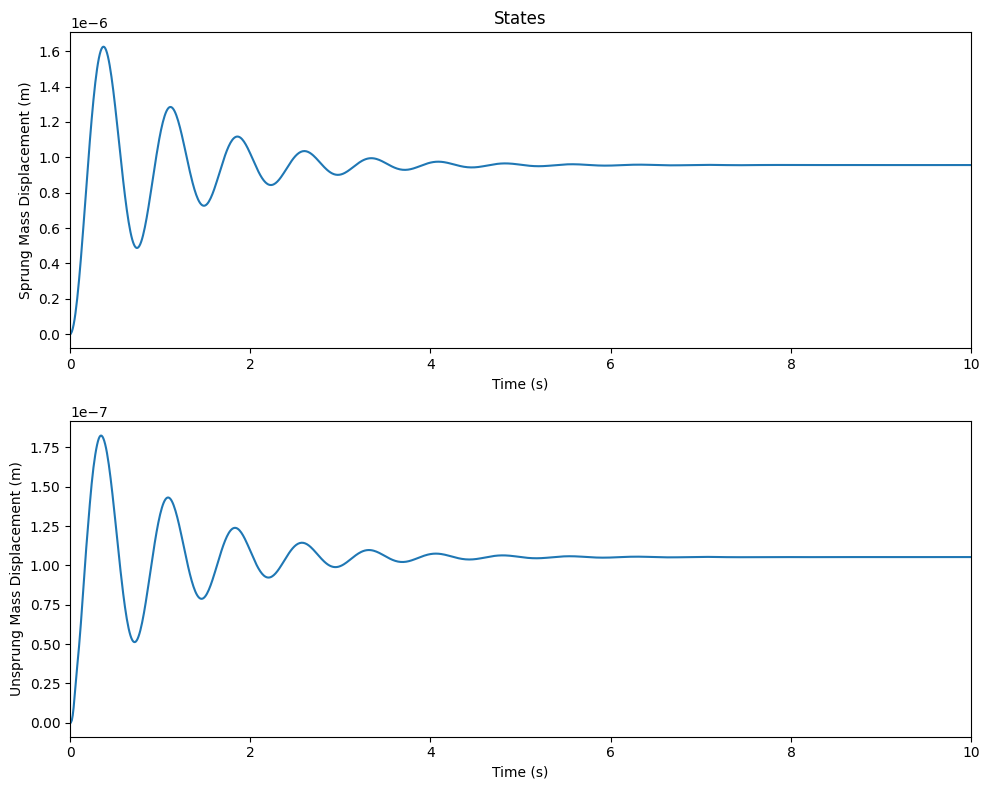

In [114]:
n_y, n_u = 3, 2  # number of delayed outputs and controls
x0 = np.array([0.0, 0.0, 0.0, 0.0])
plant = QuarterCarSuspension(x0)
r = 0.02 * np.ones((len(plant.t_vec), 1), dtype=float)  # Regulation
r_dot = np.zeros((len(plant.t_vec), 1), dtype=float)
r_ddot = np.zeros((len(plant.t_vec), 1), dtype=float)

r_dict = {"r": r, "r_dot": r_dot, "r_ddot": r_ddot}
results = simulation_ol(plant, r_dict, ref=False)
plots_state(plant, r, results)


### Reference model's response to step input

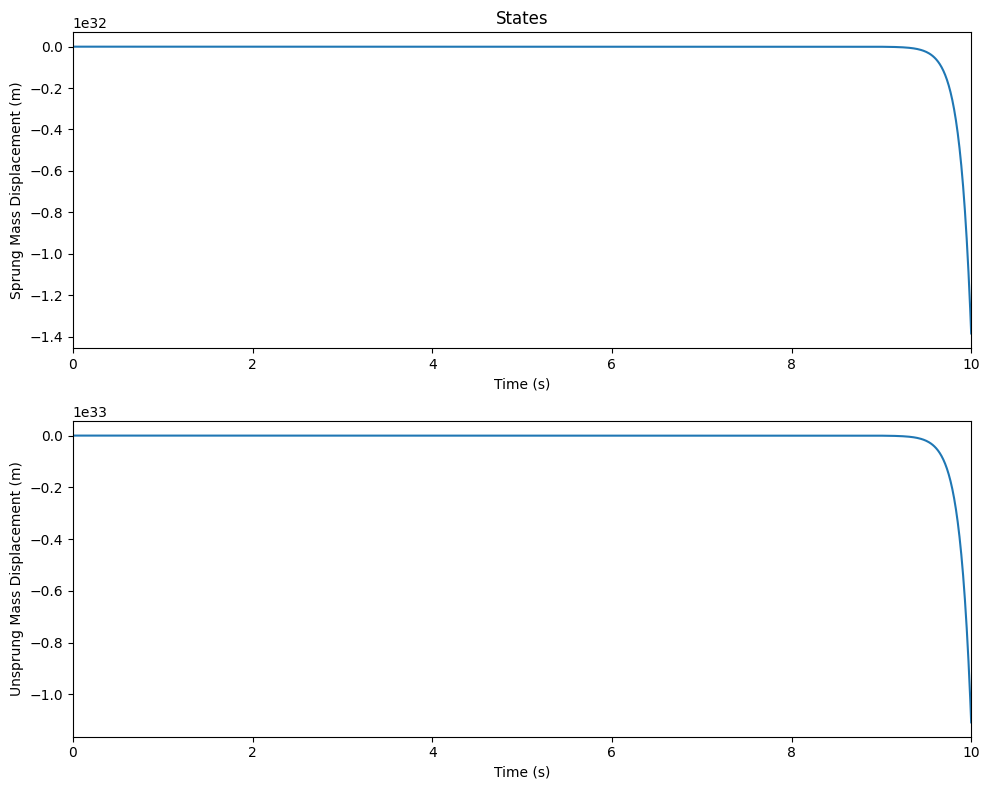

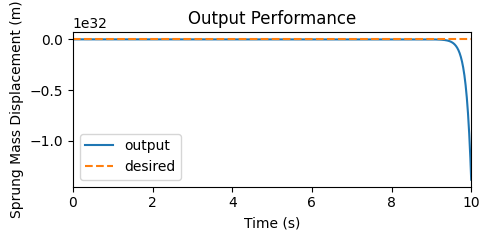

In [115]:
results = simulation_ol(plant, r_dict, ref=True)
plots_state(plant, r, results)
plots_output(plant, r, results)



### Reference model's response to sine input

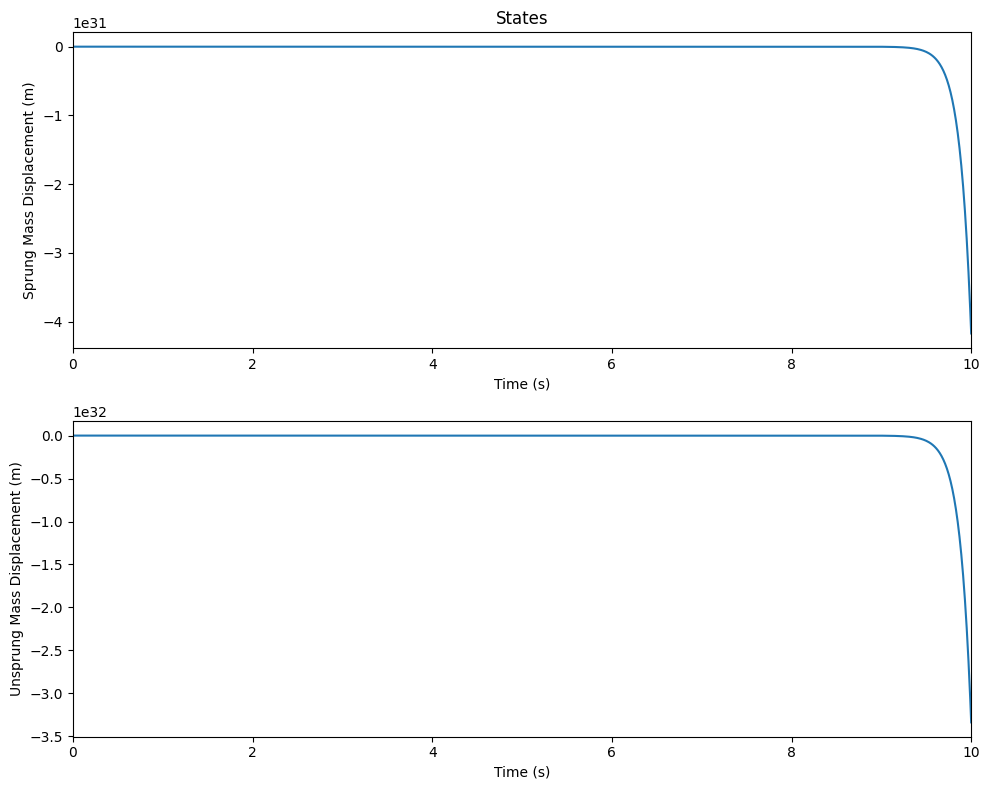

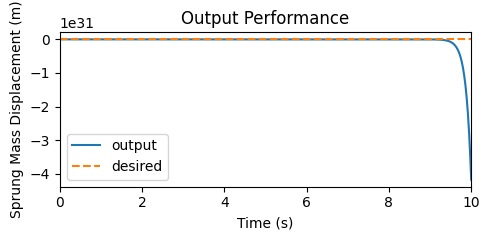

In [116]:
r = 0.02 * np.sin(plant.t_vec)  # Tracking (sine wave)
r_dot = 0.02 * np.cos(plant.t_vec)
r_ddot = -0.02 * np.sin(plant.t_vec)

r_dict = {"r": r, "r_dot": r_dot, "r_ddot": r_ddot}
results = simulation_ol(plant, r_dict, ref=True)
plots_state(plant, r, results)
plots_output(plant, r, results)



## Closed-loop simulation and training 

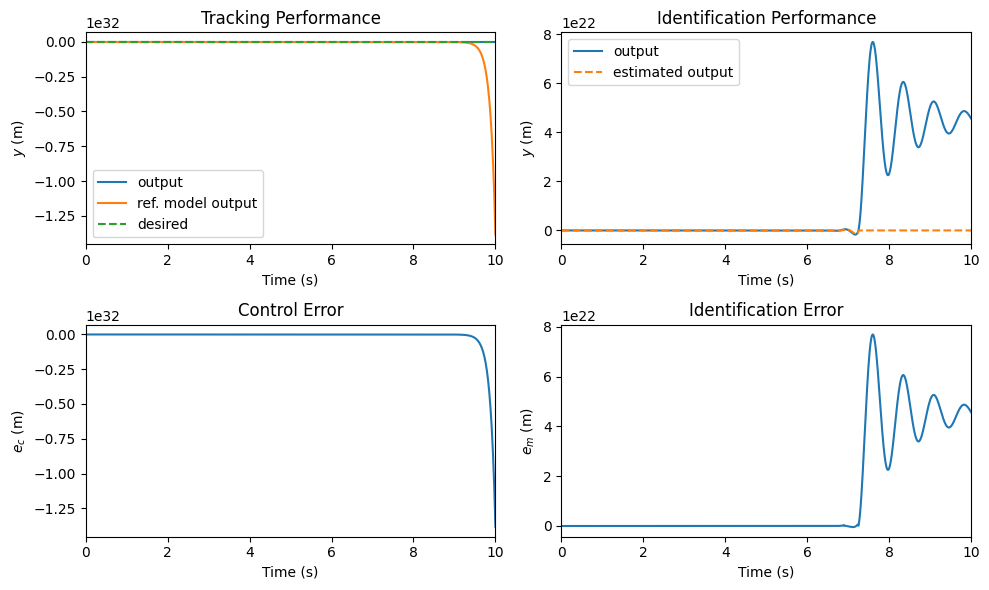

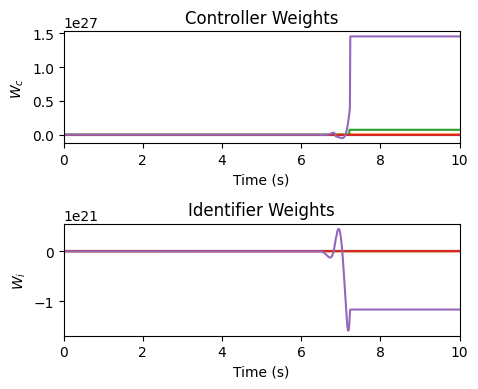

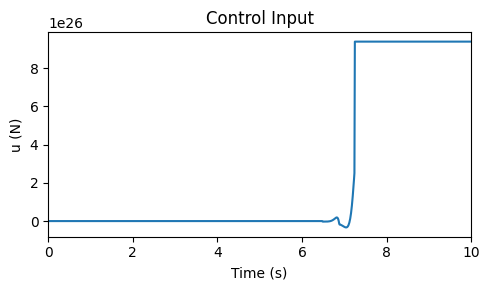

In [117]:
x0 = np.array([0.0, 0.0, 0.0, 0.0])
plant = QuarterCarSuspension(x0, T_f=10)
Regulation = True
if Regulation:
    r = 0.02 * np.ones((len(plant.t_vec), 1), dtype=float)  # Regulation
    r_dot = np.zeros((len(plant.t_vec), 1), dtype=float)
    r_ddot = np.zeros((len(plant.t_vec), 1), dtype=float)
else:
    r = 0.02 * np.sin(plant.t_vec)  # Tracking (sine wave)
    r_dot = 0.02 * np.cos(plant.t_vec)
    r_ddot = -0.02 * np.sin(plant.t_vec)
r_dict = {"r": r, "r_dot": r_dot, "r_ddot": r_ddot}

n_y, n_u = 3, 3
controller = RBFNN_Controller(input_dim=n_y + n_u + 1, num_neurons=5, eta_1=0.01, eta_2=0.002, eta_3=0.005)
identifier = RBFNN_Identifier(input_dim=n_y + n_u + 1, num_neurons=5, eta_1=0.3, eta_2=0.005, eta_3=0.01)

results = simulation_cl(plant, r_dict, controller, identifier, n_y, n_u)
plots_performance(plant, r, results)
plots_weights(plant, results)
plots_control(plant, results)